In [1]:
import os
import pymeshlab
from time import sleep
import shlex, subprocess
from io import BytesIO
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
similarity_matrix_location = "./Lizard-Mechanism/lizard_all_components_similarity_matrix.csv"

In [3]:

### Global Constants ###
reeb_graph = "/home/ubuntu/reeb_graph"
models_dir = "/home/ubuntu/fa3ds/backend/assemble/assemble_utils/models"
wrl_header = \
"""
#VRML V2.0 utf8
WorldInfo {
    info [
        "This file was created by the GICL Sat2Vrml program",
        "http://gicl.mcs.drexel.edu/",
        "Drexel University",
        "Released under the GNU GPL",
        "Copyright (C) 2001 Daniel Lapadat"
    ]
    title "GICL Sat2Vrml"
}
Viewpoint {
    fieldOfView 0.785398
    position 50 50 300
    orientation 0 0 1 0
    description "Front"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 50 50 -200
    orientation 1 0 0 3.141593
    description "Back"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 300 50 50
    orientation 0 1 0 1.570796
    description "Right Side"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position -200 50 50
    orientation 0 1 0 -1.570796
    description "Left Side"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 50 300 50
    orientation 1 0 0 -1.570796
    description "Top"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 50 -200 50
    orientation 1 0 0 1.570796
    description "Bottom"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position 200 200 200
    orientation 1 -1 0 -1.047198
    description "Diagonal Top"
    jump TRUE
}
Viewpoint {
    fieldOfView 0.785398
    position -100 -100 -100
    orientation 1 -1 0 2.094395
    description "Diagonal Bottom"
    jump TRUE
}
NavigationInfo {
    avatarSize [0.25, 1.6, 0.75]
    headlight TRUE
    speed 1.0
    type ["EXAMINE", "ANY"]
    visibilityLimit 0.0
}
Transform {
        children [
            Shape {
                geometry IndexedFaceSet {
                    coord Coordinate {
                        point [
"""
wrl_end_point = \
"""
                    ] #end of point
                } #end of Coordinate
                coordIndex [
"""
wrl_footer = \
"""
                ] #end of coordIndex
            } #end of geometry
            appearance Appearance {
                material Material {
                    diffuseColor 0.7 0.7 0.7
                    emissiveColor 0.05 0.05 0.05
                    specularColor 1.0 1.0 1.0
                    ambientIntensity 0.2
                    shininess 0.2
                    transparency 0.0
                } #end of material
            } #end of appearance
        } #end of Shape
    ] #end of children
}
"""

def similarity(mesh_set, arg1 = 4000, mu = 0.0005, arg2 = 128, arg3 = 0.5):
    """
    Computes the similarities between a set of meshes

    Inputs
        :mesh_set: <pymeshlab.MeshSet> a set of meshes to be evaluated for similarity
        :arg1: <float>
        :mu: <float>
        :arg2: <float>
        :arg3: <float>

    Outputs
        :returns: <dict> mapping mesh -> most similar other mesh
    """
    model_paths = []
    for i, mesh in enumerate(mesh_set):
        if(os.path.exists(f"{models_dir}/model_{i}.wrl")):
            True
        faces, vertices = mesh.face_matrix(), mesh.vertex_matrix()
        model_path = f"{models_dir}/model_{i}.wrl"

        model_paths.append(model_path)
        _save_as_wrl(faces, vertices, model_path)

    command_0 = "echo " + "\n".join(model_path for model_path in model_paths)
    process_0 = _exec(command_0, keep_output = True)
    print('Extracting Reeb graphs...')
    command_1 = f"xargs  java -cp \"{reeb_graph}/src/\" -Xmx1024m ExtractReebGraph {arg1} {mu} {arg2}"
    process_1 = _exec(command_1, stdin = process_0.stdout)
    print('Done Extracting!')

    command_0 = "echo " + "\n".join(model_path for model_path in model_paths)
    process_0 = _exec(command_0, keep_output = True)
    print('Comparing Reeb graphs...')
    command_2 = f"xargs  java -cp \"{reeb_graph}/src/\" -Xmx1024m CompareReebGraph {arg1} {mu} {arg2} {arg3}" 
    process_2 = _exec(command_2, stdin = process_0.stdout)
    print('Done comparing!')
    
    out = process_2.stdout.decode('utf8').strip().split("\n")
    print('Processing output')
    for line in out:
        model_1, model_2, sim = line.split(",")
        name_1, _ = os.path.splitext(model_1)
        name_2, _ = os.path.splitext(model_2)
        name_1, name_2 = name_1.split("/")[-1], name_2.split("/")[-1]

        print(f"[out] >> {name_1} ~ {name_2} = {float(sim):.3f}")
        
        with open(similarity_matrix_location, "a") as fi:
            fi.write(f"{name_1},{name_2},{float(sim):.3f}\n")
    print('Storing all models')        
    
    _exec(f"rm -rf {models_dir}")
    _exec(f"mkdir {models_dir}")

    for i, mesh in enumerate(mesh_set):
        ms.set_current_mesh(i)
        ms.save_current_mesh(f"{models_dir}/model_{i}.obj")

### Helper Functions ###
def _exec(command: str, wait: int = None, stdin = None, keep_output = False) -> subprocess:
    """
    Executes a command using a subprocess and returns the execution subprocess

    Inputs
        :command: <str> command to execute 
        :wait: <int> amount of time to wait for command to execute
    
    Outputs
        :subprocess: <subprocess> a sub-process that runs the executed command
    """
    # print(f"[cmd] >> {command}")
    command = shlex.split(command)
    if not keep_output: process = subprocess.run(command, stdout=subprocess.PIPE, stdin=stdin)
    else: process = subprocess.Popen(command, stdout=subprocess.PIPE, stdin=stdin)
        
    if wait is not None: sleep(wait)
    return process

def _save_as_wrl(faces, vertices, path):
    """
    Export given list of Mesh objects to a VRML file.

    Inputs
        :faces: <np.ndarray> of size (f, 3) for f faces
        :vertices: <np.ndarray> of size (v, 3) for v vertices
        :path: path to store vrml to 
    """
    # print("Converting to wrl ...")
    with open(path, 'w') as wrl:
        # write the standard VRML header
        wrl.write(wrl_header)

        #write coordinates (x, y, z) for each vertex
        wrl.write("\t\t\t\t\t\t" + "\n\t\t\t\t\t\t".join(f"{v[0]:.3f} {v[1]:.3f} {v[2]:.3f}," for v in vertices))
        wrl.write(wrl_end_point)
        
        # write vertex indexes for each face
        wrl.write("\t\t\t\t\t\t" + "\n\t\t\t\t\t\t".join(f"{f[0]}, {f[1]}, {f[2]}, -1," for f in faces))
        wrl.write(wrl_footer) 
    # print("--- Done ---")

In [5]:
mesh_path_1 = "/home/ubuntu/fa3ds/backend/assemble/Experiments/model_20/5_segmentation/segment_1.0/segment_1.0.obj"
mesh_path_2 = "/home/ubuntu/fa3ds/backend/assemble/Experiments/model_20/5_segmentation/segment_2.0/segment_2.0.obj"

In [20]:
mesh_list = []
for root, dirs, files in os.walk('/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism'):
    for name in files:
        file_path = os.path.join(root, name)
        if file_path.endswith(".obj"):
            mesh_list.append(file_path)
print(mesh_list)

# for root, dirs, files in os.walk('/home/ubuntu/fa3ds/backend/assemble/Experiments/model_20'):
#     for name in files:
#         file_path = os.path.join(root, name)
#         if file_path.endswith(".obj"):
#             mesh_list.append(file_path)
# print(mesh_list)

['/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_4.0/segment_4.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_1.0/segment_1.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_3.0/segment_3.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_0.0/segment_0.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_2.0/segment_2.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_5.0/segment_5.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_39/6_segmentation/segment_4.0/segment_4.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_39/6_segmentation/segment_1.0/segment_1.0.obj', '/home/ubuntu/fa3ds/backend/assemble/Ex

In [21]:
ms = pymeshlab.MeshSet()
for mesh_path in mesh_list:
    print(mesh_path)
    ms.load_new_mesh(mesh_path)

similarity(ms)

/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_4.0/segment_4.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_1.0/segment_1.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_3.0/segment_3.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_0.0/segment_0.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_2.0/segment_2.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_33/6_segmentation/segment_5.0/segment_5.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_39/6_segmentation/segment_4.0/segment_4.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_39/6_segmentation/segment_1.0/segment_1.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism

/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_34/6_segmentation/segment_3.0/segment_3.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_34/6_segmentation/segment_0.0/segment_0.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_34/6_segmentation/segment_2.0/segment_2.0.obj
/home/ubuntu/fa3ds/backend/assemble/Experiments/Lizard-Mechanism/model_34/6_segmentation/segment_5.0/segment_5.0.obj
Extracting Reeb graphs...
Done Extracting!
Comparing Reed graphs...
Done comparing!
Processing output
[out] >> model_0 ~ model_0 = 1.000
[out] >> model_0 ~ model_1 = 0.194
[out] >> model_0 ~ model_2 = 0.102
[out] >> model_0 ~ model_3 = 0.555
[out] >> model_0 ~ model_4 = 0.106
[out] >> model_0 ~ model_5 = 0.475
[out] >> model_0 ~ model_6 = 0.113
[out] >> model_0 ~ model_7 = 0.204
[out] >> model_0 ~ model_8 = 0.089
[out] >> model_0 ~ model_9 = 0.089
[out] >> model_0 ~ model_10 = 0.089
[out] >> model_0 ~ model_11 = 0.109
[out] >>

In [11]:
csv_file = pd.read_csv(similarity_matrix_location)
array = np.zeros((93,93),dtype='float64')
for index, element in csv_file.iterrows():
    model_1,model_2,score = element
    array[int(model_1.split('_')[-1]), int(model_2.split('_')[-1])] = float(score)

In [12]:
array

array([[0.   , 0.194, 0.102, ..., 0.099, 0.089, 0.418],
       [0.194, 1.   , 0.125, ..., 0.125, 0.125, 0.567],
       [0.102, 0.125, 1.   , ..., 0.802, 0.619, 0.153],
       ...,
       [0.099, 0.125, 0.802, ..., 1.   , 0.592, 0.151],
       [0.089, 0.125, 0.619, ..., 0.592, 1.   , 0.141],
       [0.418, 0.567, 0.153, ..., 0.151, 0.141, 1.   ]])

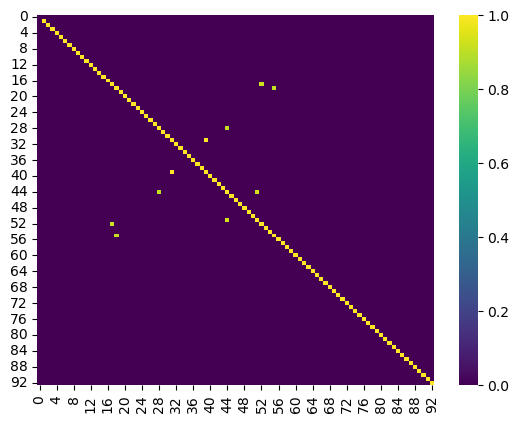

In [29]:
swarm_plot = sns.heatmap(array, annot=False, fmt="g", cmap='viridis')
fig = swarm_plot.get_figure()
fig.savefig("./heatmap.png") 

In [28]:
for index_1, row in enumerate(array):
    for index_2, value in enumerate(row): 
        if(value <= 0.8):
            array[index_1][index_2] = 0
        elif(not index_1 == index_2 ):
            print(index_1, index_2)

17 52
18 55
28 44
31 39
39 31
44 28
44 51
51 44
52 17
55 18


In [ ]:
mechanism_locations = ['/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_31/6_segmentation/segment_1.0/segment_1.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_31/6_segmentation/segment_3.0/segment_3.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_31/6_segmentation/segment_4.0/segment_4.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_32/6_segmentation/segment_2.0/segment_2.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_32/6_segmentation/segment_4.0/segment_4.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_32/6_segmentation/segment_5.0/segment_5.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_33/6_segmentation/segment_1.0/segment_1.0.obj',
                      '/home/ubuntu/fa3ds/backend/results/api_segmented_models/model_33/6_segmentation/segment_2.0/segment_2.0.obj',
                      '']